# Neural Machine Translation

- This notebook serves as a complete documentation of Assignment 4 of CS224N Winter 2019 Natural Language Processing (NLP). It is a walkthrough of the formulation and basis of the code implementation of the Neural Machine Translation (NMT) model required by the assignment.


### Assignment 1

### Architecture to implement

In [25]:
from collections import namedtuple
import sys
from typing import List, Tuple, Dict, Set, Union
import torch
import torch.nn as nn
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [2]:
from IPython import display

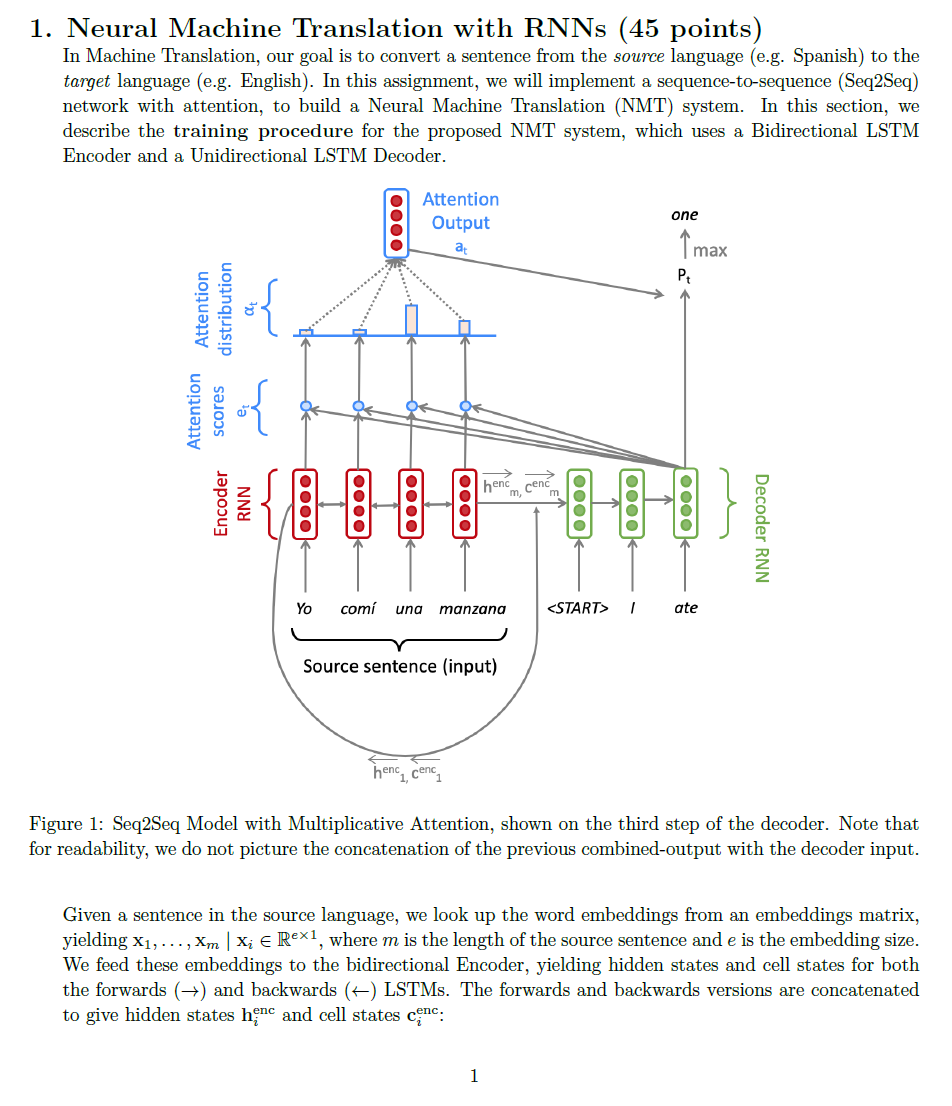

In [3]:
display.Image("./raw/a4_1.png")

Since we are using LSTM, LSTM has hidden states and cell states

Background of hidden states and cell states

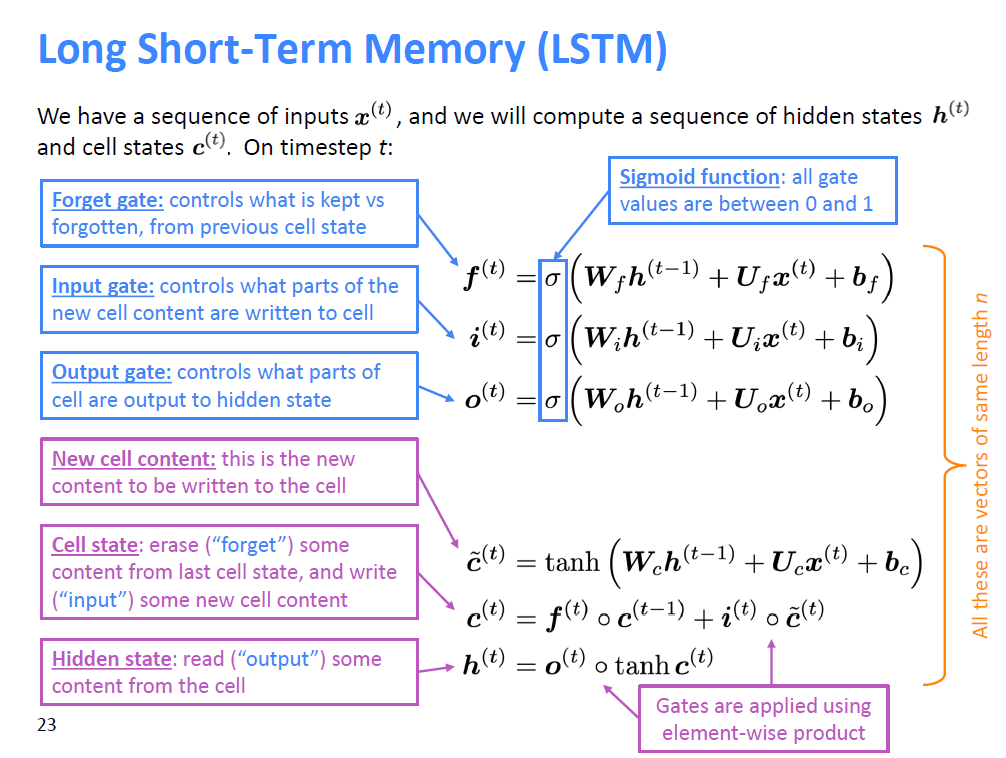

In [4]:
display.Image("./raw/a4_2.png")

#### Question 1a

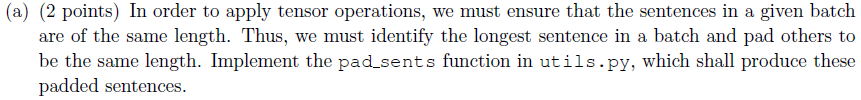

In [5]:
display.Image("./raw/a4_q1a.png")

In [6]:
# source: utils.py

def pad_sents(sents, pad_token):
    """ Pad list of sentences according to the longest sentence in the batch.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded = []

    ### YOUR CODE HERE (~6 Lines)

    ### END YOUR CODE

    return sents_padded

we want to pad all sentences to the same length because the NMT can only take in a X embedding matrix of the same dimensions

#1. identify the longest sentence in a batch and pad others to the same length
    
>    `max_len = max([len(sent) for sent in sents])`
    
#2. pad others to the same length

>    `for sent in sents:
>        if len(sent) < max_len:
>            sents_padded.append(sent+[pad_token]*(max_len-len(sent)))
>        else:
>            sents_padded.append(sent)`

In [7]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences according to the longest sentence in the batch.
    @param sents (list[list[str]]): list of sentences, where each sentence
                                    is represented as a list of words
    @param pad_token (str): padding token
    @returns sents_padded (list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentences in the batch now has equal length.
    """
    sents_padded = []

    ### YOUR CODE HERE (~6 Lines)
    max_len = max([len(sent) for sent in sents])
    for sent in sents:
        if len(sent) < max_len:
            sents_padded.append(sent+[pad_token]*(max_len-len(sent)))
        else:
            sents_padded.append(sent)
    ### END YOUR CODE

    return sents_padded

#### Question 1b

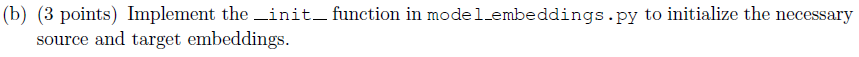

In [8]:
display.Image("./raw/a4_q1b.png")

In [9]:
# source: model_embeddings.py

import torch.nn as nn

class ModelEmbeddings(nn.Module): 
    """
    Class that converts input words to their embeddings.
    """
    def __init__(self, embed_size, vocab):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        # default values
        self.source = None
        self.target = None

        src_pad_token_idx = vocab.src['<pad>']
        tgt_pad_token_idx = vocab.tgt['<pad>']

        ### YOUR CODE HERE (~2 Lines)
        ### TODO - Initialize the following variables:
        ###     self.source (Embedding Layer for source language)
        ###     self.target (Embedding Layer for target langauge)
        ###
        ### Note:
        ###     1. `vocab` object contains two vocabularies:
        ###            `vocab.src` for source
        ###            `vocab.tgt` for target
        ###     2. You can get the length of a specific vocabulary by running:
        ###             `len(vocab.<specific_vocabulary>)`
        ###     3. Remember to include the padding token for the specific vocabulary
        ###        when creating your Embedding.
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        


        ### END YOUR CODE

So we have to initialize the source embedding layer and target embedding layer.
Recall earlier,

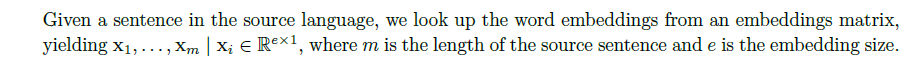

In [10]:
display.Image("./raw/a4_5.png")

we are given the hint to use torch.nn.Embedding

from https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

- nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, norm_type=2.0, scale_grad_by_freq=False, sparse=False, _weight=None, device=None, dtype=None)

parameters of the class torch.nn.Embedding

- num_embeddings = number of words in vocabulary
- embedding_dim = dimension of hidden state
- padding_idx = index of padding token

therefore,

- num_embeddings = len(vocab.src) or len(vocab.tgt)
- embedding_dim = self.embed_size
- padding_idx = src_pad_token_idx or tgt_pad_token_idx

> `self.source = nn.Embedding(len(vocab.src) , self.embed_size, padding_idx=src_pad_token_idx)`

> `self.target = nn.Embedding(len(vocab.tgt) , self.embed_size, padding_idx=tgt_pad_token_idx)`

In [11]:
class ModelEmbeddings(nn.Module): 
    """
    Class that converts input words to their embeddings.
    """
    def __init__(self, embed_size, vocab):
        """
        Init the Embedding layers.

        @param embed_size (int): Embedding size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        """
        super(ModelEmbeddings, self).__init__()
        self.embed_size = embed_size

        # default values
        self.source = None
        self.target = None

        src_pad_token_idx = vocab.src['<pad>']
        tgt_pad_token_idx = vocab.tgt['<pad>']

        ### YOUR CODE HERE (~2 Lines)
        ### TODO - Initialize the following variables:
        ###     self.source (Embedding Layer for source language)
        ###     self.target (Embedding Layer for target langauge)
        ###
        ### Note:
        ###     1. `vocab` object contains two vocabularies:
        ###            `vocab.src` for source
        ###            `vocab.tgt` for target
        ###     2. You can get the length of a specific vocabulary by running:
        ###             `len(vocab.<specific_vocabulary>)`
        ###     3. Remember to include the padding token for the specific vocabulary
        ###        when creating your Embedding.
        ###
        ### Use the following docs to properly initialize these variables:
        ###     Embedding Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        
        # Embedding matrix for all vocabularies in both source target embeddings
        self.source = nn.Embedding(len(vocab.src) , self.embed_size, padding_idx=src_pad_token_idx)
        self.target = nn.Embedding(len(vocab.tgt) , self.embed_size, padding_idx=tgt_pad_token_idx)

        ### END YOUR CODE

#### Question 1c

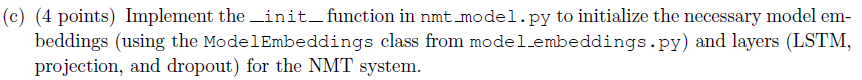

In [12]:
display.Image("./raw/a4_q1c.png")

In [13]:
# source: nmt_model.py
class NMT(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, embed_size, hidden_size, vocab, dropout_rate=0.2):
        """ Init NMT Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(NMT, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab

        # default values
        self.encoder = None 
        self.decoder = None
        self.h_projection = None
        self.c_projection = None
        self.att_projection = None
        self.combined_output_projection = None
        self.target_vocab_projection = None
        self.dropout = None


        ### YOUR CODE HERE (~8 Lines)
        ### TODO - Initialize the following variables:
        ###     self.encoder (Bidirectional LSTM with bias)
        ###     self.decoder (LSTM Cell with bias)
        ###     self.h_projection (Linear Layer with no bias), called W_{h} in the PDF.
        ###     self.c_projection (Linear Layer with no bias), called W_{c} in the PDF.
        ###     self.att_projection (Linear Layer with no bias), called W_{attProj} in the PDF.
        ###     self.combined_output_projection (Linear Layer with no bias), called W_{u} in the PDF.
        ###     self.target_vocab_projection (Linear Layer with no bias), called W_{vocab} in the PDF.
        ###     self.dropout (Dropout Layer)
        ###
        ### Use the following docs to properly initialize these variables:
        ###     LSTM:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        ###     LSTM Cell:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell
        ###     Linear Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        ###     Dropout Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        
        ### END YOUR CODE

TODO - Initialize the following variables:
- self.encoder (Bidirectional LSTM with bias)
- self.decoder (LSTM Cell with bias)
- self.h_projection (Linear Layer with no bias), called W_{h} in the PDF.
- self.c_projection (Linear Layer with no bias), called W_{c} in the PDF.
- self.att_projection (Linear Layer with no bias), called W_{attProj} in the PDF.
- self.combined_output_projection (Linear Layer with no bias), called W_{u} in the PDF.
- self.target_vocab_projection (Linear Layer with no bias), called W_{vocab} in the PDF.
- self.dropout (Dropout Layer)

#### for self.encoder (Bidirectional LSTM with bias)

from https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- nn.LSTM()

Parameters of nn.LSTM()

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional LSTM. Default: False

proj_size – If > 0, will use LSTM with projections of corresponding size. Default: 0

> `self.encoder = nn.LSTM(input_size=embed_size,hidden_size=self.hidden_size,num_layers=1,bidirectional=True,bias=True)`

#### self.decoder (LSTM Cell with bias)
- nn.LSTMCell(input_size, hidden_size, bias=True, device=None, dtype=None)

> `self.decoder = nn.LSTMCell(input_size=embed_size+self.hidden_size,hidden_size=self.hidden_size,bias=True)`

#### self.h_projection (Linear Layer with no bias), called W_{h} in the PDF.
#### self.c_projection (Linear Layer with no bias), called W_{c} in the PDF.

Recall,

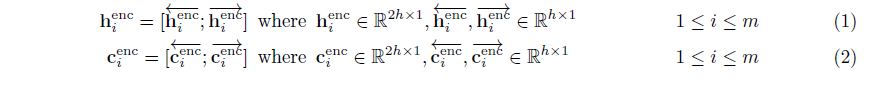

In [14]:
display.Image("./raw/a4_3.png")

and recall,

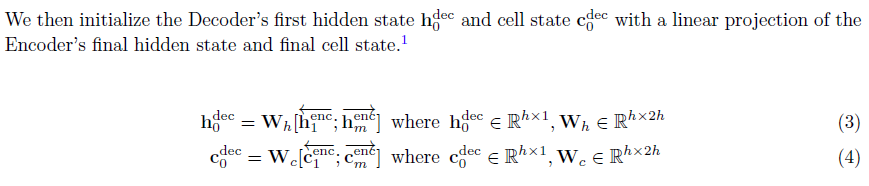

In [15]:
display.Image("./raw/a4_4.png")

- nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

parameters of nn.Linear
- in_features = 2 X enbedding size
- out_features = embedding size

> `self.h_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)`

> `self.c_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)`

#### self.att_projection (Linear Layer with no bias), called W_{attProj} in the PDF.

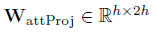

In [16]:
display.Image("./raw/a4_6.png")

> `self.att_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)`

#### self.combined_output_projection (Linear Layer with no bias), called W_{u} in the PDF.

In [30]:
display.Image("./raw/a4_7.png")

> `self.att_projection = nn.Linear(self.hidden_size*3,self.hidden_size,bias=False)`

#### self.target_vocab_projection (Linear Layer with no bias), called W_{vocab} in the PDF.

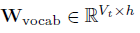

In [31]:
display.Image("./raw/a4_8.png")

> `self.target_vocab_projection = nn.Linear(self.hidden_size,len(vocab.tgt),bias=False)`

#### self.dropout (Dropout Layer)

> `self.dropout = nn.Dropout(self.dropout_rate)`

In [19]:
class NMT(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, embed_size, hidden_size, vocab, dropout_rate=0.2):
        """ Init NMT Model.

        @param embed_size (int): Embedding size (dimensionality)
        @param hidden_size (int): Hidden Size (dimensionality)
        @param vocab (Vocab): Vocabulary object containing src and tgt languages
                              See vocab.py for documentation.
        @param dropout_rate (float): Dropout probability, for attention
        """
        super(NMT, self).__init__()
        self.model_embeddings = ModelEmbeddings(embed_size, vocab)
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.vocab = vocab

        # default values
        self.encoder = None 
        self.decoder = None
        self.h_projection = None
        self.c_projection = None
        self.att_projection = None
        self.combined_output_projection = None
        self.target_vocab_projection = None
        self.dropout = None


        ### YOUR CODE HERE (~8 Lines)
        ### TODO - Initialize the following variables:
        ###     self.encoder (Bidirectional LSTM with bias)
        ###     self.decoder (LSTM Cell with bias)
        ###     self.h_projection (Linear Layer with no bias), called W_{h} in the PDF.
        ###     self.c_projection (Linear Layer with no bias), called W_{c} in the PDF.
        ###     self.att_projection (Linear Layer with no bias), called W_{attProj} in the PDF.
        ###     self.combined_output_projection (Linear Layer with no bias), called W_{u} in the PDF.
        ###     self.target_vocab_projection (Linear Layer with no bias), called W_{vocab} in the PDF.
        ###     self.dropout (Dropout Layer)
        ###
        ### Use the following docs to properly initialize these variables:
        ###     LSTM:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        ###     LSTM Cell:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell
        ###     Linear Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        ###     Dropout Layer:
        ###         https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout
        
        self.encoder = nn.LSTM(input_size=embed_size,hidden_size=self.hidden_size,num_layers=1,bidirectional=True,bias=True)
        self.decoder = nn.LSTMCell(input_size=embed_size+self.hidden_size,hidden_size=self.hidden_size,bias=True)
        self.h_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)
        self.c_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)
        self.att_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)
        self.combined_output_projection = nn.Linear(self.hidden_size*3,self.hidden_size,bias=False)
        self.target_vocab_projection = nn.Linear(self.hidden_size,len(vocab.tgt),bias=False)
        self.dropout = nn.Dropout(self.dropout_rate)

        ### END YOUR CODE

### Summary

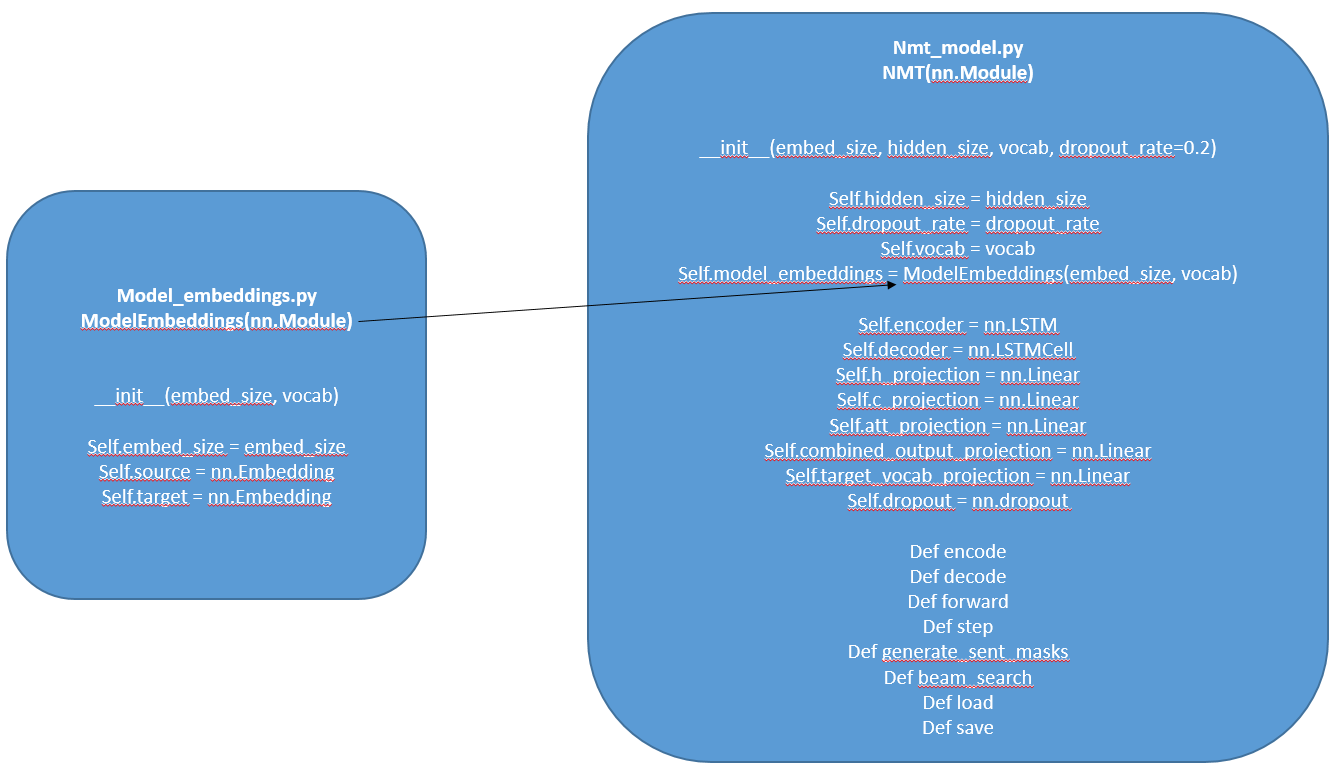

In [20]:
display.Image("./raw/a4_uml.png")

#### Question 1d

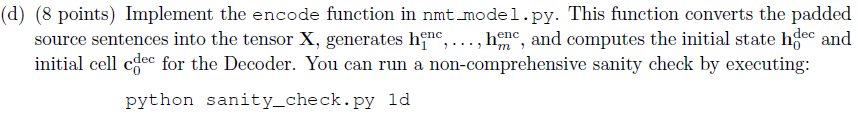

In [21]:
display.Image("./raw/a4_q1d.png")

after initializing all the variables, now it's time to piece them together and let it run like clockwork

In [26]:
def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    """ Apply the encoder to source sentences to obtain encoder hidden states.
        Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

    @param source_padded (Tensor): Tensor of padded source sentences with shape (src_len, b), where
                                    b = batch_size, src_len = maximum source sentence length. Note that 
                                   these have already been sorted in order of longest to shortest sentence.
    @param source_lengths (List[int]): List of actual lengths for each of the source sentences in the batch
    @returns enc_hiddens (Tensor): Tensor of hidden units with shape (b, src_len, h*2), where
                                    b = batch size, src_len = maximum source sentence length, h = hidden size.
    @returns dec_init_state (tuple(Tensor, Tensor)): Tuple of tensors representing the decoder's initial
                                            hidden state and cell.
    """
    enc_hiddens, dec_init_state = None, None

    ### YOUR CODE HERE (~ 8 Lines)
    ### TODO:
    ###     1. Construct Tensor `X` of source sentences with shape (src_len, b, e) using the source model embeddings.
    ###         src_len = maximum source sentence length, b = batch size, e = embedding size. Note
    ###         that there is no initial hidden state or cell for the decoder.
    ###     2. Compute `enc_hiddens`, `last_hidden`, `last_cell` by applying the encoder to `X`.
    ###         - Before you can apply the encoder, you need to apply the `pack_padded_sequence` function to X.
    ###         - After you apply the encoder, you need to apply the `pad_packed_sequence` function to enc_hiddens.
    ###         - Note that the shape of the tensor returned by the encoder is (src_len, b, h*2) and we want to
    ###           return a tensor of shape (b, src_len, h*2) as `enc_hiddens`.
    ###     3. Compute `dec_init_state` = (init_decoder_hidden, init_decoder_cell):
    ###         - `init_decoder_hidden`:
    ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
    ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
    ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
    ###             This is h_0^{dec} in the PDF. Here b = batch size, h = hidden size
    ###         - `init_decoder_cell`:
    ###             `last_cell` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
    ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
    ###             Apply the c_projection layer to this in order to compute init_decoder_cell.
    ###             This is c_0^{dec} in the PDF. Here b = batch size, h = hidden size
    ###
    ### See the following docs, as you may need to use some of the following functions in your implementation:
    ###     Pack the padded sequence X before passing to the encoder:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
    ###     Pad the packed sequence, enc_hiddens, returned by the encoder:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_packed_sequence
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Permute:
    ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute

    ### END YOUR CODE

    return enc_hiddens, dec_init_state

`encode` takes in two parameters

#### Steps
A. Apply the encoder to source sentences to obtain encoder hidden states.

B. Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

### A

1. Construct Tensor `X` of source sentences with shape (src_len, b, e) using the source model embeddings.
         src_len = maximum source sentence length, b = batch size, e = embedding size. Note
         that there is no initial hidden state or cell for the decoder.

recall, in class `model_embeddings`

`self.source = nn.Embedding(len(vocab.src) , self.embed_size, padding_idx=src_pad_token_idx)`

`self.model_embeddings.source` requires 2 parameters

`source_padded` as an input parameter of `encode()`, has shape `(src_len, b)`

> `X = self.model_embeddings.source(source_padded)`

2. Compute `enc_hiddens`, `last_hidden`, `last_cell` by applying the encoder to `X`.
- Before you can apply the encoder, you need to apply the `pack_padded_sequence` function to X.

> `X = nn.utils.rnn.pack_padded_sequence(X,lengths=source_lengths)`

- apply the encoder i.e. nn.LSTM

> `enc_hiddens, (last_hidden, last_cell) = self.encoder(X)`

- After you apply the encoder, you need to apply the `pad_packed_sequence` function to `enc_hiddens`.

> `enc_hiddens = nn.utils.rnn.pad_packed_sequence(enc_hiddens)`

- Note that the shape of the tensor returned by the encoder is (src_len, b, h*2) and we want to 
return a tensor of shape (b, src_len, h*2) as `enc_hiddens`.

> `enc_hiddens = enc_hiddens.permute(1,0,2)`

### B

3. Compute `dec_init_state` = (init_decoder_hidden, init_decoder_cell):
         - `init_decoder_hidden`:
             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
             Apply the h_projection layer to this in order to compute init_decoder_hidden.
             This is h_0^{dec} in the PDF. Here b = batch size, h = hidden size

Recall

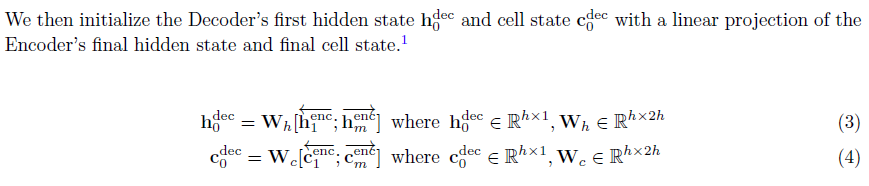

In [38]:
display.Image("./raw/a4_4.png")

> `self.h_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)`

> `self.c_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)`

         - `init_decoder_cell`:
             `last_cell` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
             Apply the c_projection layer to this in order to compute init_decoder_cell.
             This is c_0^{dec} in the PDF. Here b = batch size, h = hidden size

> `init_decoder_hidden = self.h_projection(torch.cat((last_hidden[0], last_hidden[1]),1))` # note: dim = 1, concat column-wise

> `init_decoder_cell = self.c_projection(torch.cat((last_cell[0], last_cell[1]),1))` # note: dim = 1, concat column-wise

> `dec_init_state = (init_decoder_hidden, init_decoder_cell)`

In [45]:
def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    """ Apply the encoder to source sentences to obtain encoder hidden states.
        Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

    @param source_padded (Tensor): Tensor of padded source sentences with shape (src_len, b), where
                                    b = batch_size, src_len = maximum source sentence length. Note that 
                                   these have already been sorted in order of longest to shortest sentence.
    @param source_lengths (List[int]): List of actual lengths for each of the source sentences in the batch
    @returns enc_hiddens (Tensor): Tensor of hidden units with shape (b, src_len, h*2), where
                                    b = batch size, src_len = maximum source sentence length, h = hidden size.
    @returns dec_init_state (tuple(Tensor, Tensor)): Tuple of tensors representing the decoder's initial
                                            hidden state and cell.
    """
    enc_hiddens, dec_init_state = None, None

    ### YOUR CODE HERE (~ 8 Lines)
    ### TODO:
    ###     1. Construct Tensor `X` of source sentences with shape (src_len, b, e) using the source model embeddings.
    ###         src_len = maximum source sentence length, b = batch size, e = embedding size. Note
    ###         that there is no initial hidden state or cell for the decoder.
    ###     2. Compute `enc_hiddens`, `last_hidden`, `last_cell` by applying the encoder to `X`.
    ###         - Before you can apply the encoder, you need to apply the `pack_padded_sequence` function to X.
    ###         - After you apply the encoder, you need to apply the `pad_packed_sequence` function to enc_hiddens.
    ###         - Note that the shape of the tensor returned by the encoder is (src_len, b, h*2) and we want to
    ###           return a tensor of shape (b, src_len, h*2) as `enc_hiddens`.
    ###     3. Compute `dec_init_state` = (init_decoder_hidden, init_decoder_cell):
    ###         - `init_decoder_hidden`:
    ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
    ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
    ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
    ###             This is h_0^{dec} in the PDF. Here b = batch size, h = hidden size
    ###         - `init_decoder_cell`:
    ###             `last_cell` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
    ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
    ###             Apply the c_projection layer to this in order to compute init_decoder_cell.
    ###             This is c_0^{dec} in the PDF. Here b = batch size, h = hidden size
    ###
    ### See the following docs, as you may need to use some of the following functions in your implementation:
    ###     Pack the padded sequence X before passing to the encoder:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
    ###     Pad the packed sequence, enc_hiddens, returned by the encoder:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_packed_sequence
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Permute:
    ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute

    X = self.model_embeddings.source(source_padded)
    X = nn.utils.rnn.pack_padded_sequence(X,lengths=source_lengths)
    enc_hiddens, (last_hidden, last_cell) = self.encoder(X)
    enc_hiddens = nn.utils.rnn.pad_packed_sequence(enc_hiddens)[0] # (src_len, b, h*2)
    enc_hiddens = enc_hiddens.permute(1,0,2) # (b, src_len, h*2)

    init_decoder_hidden = self.h_projection(torch.cat((last_hidden[0],last_hidden[1]),1)) # (b, 2*h) `last_hidden` is a tensor shape (2, b, h)
    init_decoder_cell = self.c_projection(torch.cat((last_cell[0],last_cell[1]),1)) # (b, 2*h) `last_cell` is a tensor shape (2, b, h)
    dec_init_state = (init_decoder_hidden, init_decoder_cell)

    ### END YOUR CODE

    return enc_hiddens, dec_init_state

Hence, `encode` returns `enc_hiddens` h_i^enc

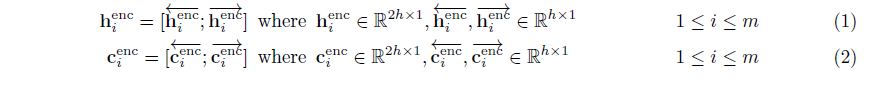

In [54]:
display.Image("./raw/a4_3.png")

and `dec_init_state`

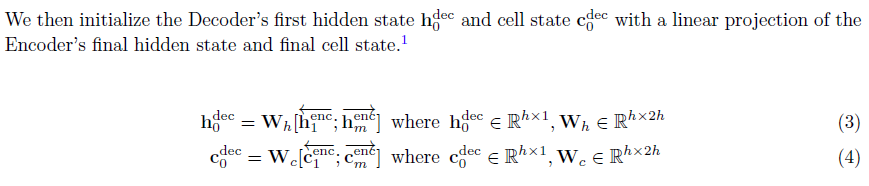

In [56]:
display.Image("./raw/a4_4.png")

And we are done with constructing the encoder segment!!!

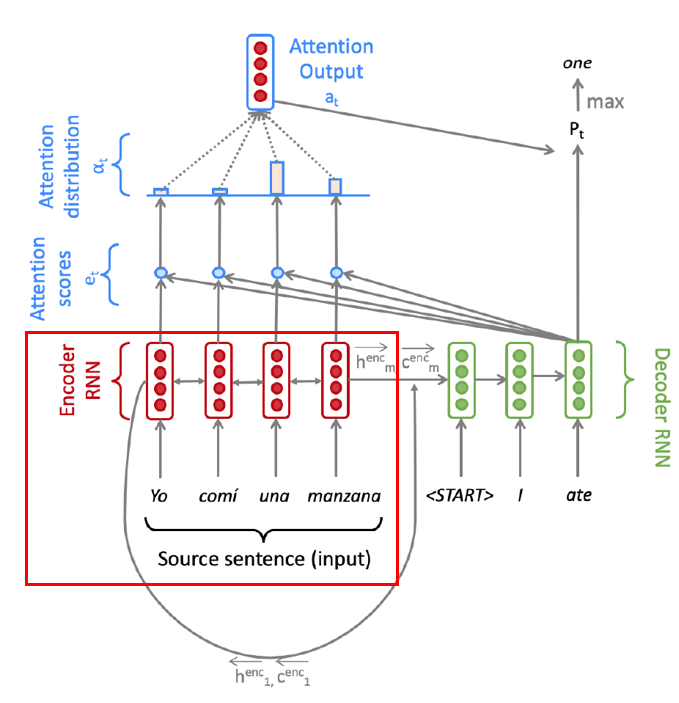

In [40]:
display.Image("./raw/a4_9.png")

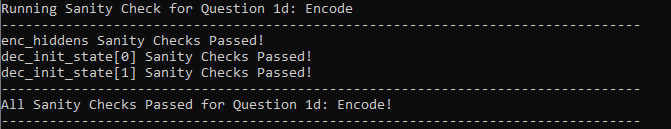

In [42]:
display.Image("./raw/a4_q1d_succ.png")

#### Question 1e

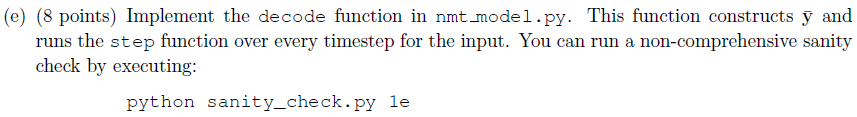

In [41]:
display.Image("./raw/a4_q1e.png")

In [43]:
def decode(self, enc_hiddens: torch.Tensor, enc_masks: torch.Tensor,
            dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
    """Compute combined output vectors for a batch.

    @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                 b = batch size, src_len = maximum source sentence length, h = hidden size.
    @param enc_masks (Tensor): Tensor of sentence masks (b, src_len), where
                                 b = batch size, src_len = maximum source sentence length.
    @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
    @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                   tgt_len = maximum target sentence length, b = batch size. 

    @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                    tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
    """
    # Chop of the <END> token for max length sentences.
    target_padded = target_padded[:-1]

    # Initialize the decoder state (hidden and cell)
    dec_state = dec_init_state

    # Initialize previous combined output vector o_{t-1} as zero
    batch_size = enc_hiddens.size(0)
    o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

    # Initialize a list we will use to collect the combined output o_t on each step
    combined_outputs = []

    ### YOUR CODE HERE (~9 Lines)
    ### TODO:
    ###     1. Apply the attention projection layer to `enc_hiddens` to obtain `enc_hiddens_proj`,
    ###         which should be shape (b, src_len, h),
    ###         where b = batch size, src_len = maximum source length, h = hidden size.
    ###         This is applying W_{attProj} to h^enc, as described in the PDF.
    ###     2. Construct tensor `Y` of target sentences with shape (tgt_len, b, e) using the target model embeddings.
    ###         where tgt_len = maximum target sentence length, b = batch size, e = embedding size.
    ###     3. Use the torch.split function to iterate over the time dimension of Y.
    ###         Within the loop, this will give you Y_t of shape (1, b, e) where b = batch size, e = embedding size.
    ###             - Squeeze Y_t into a tensor of dimension (b, e). 
    ###             - Construct Ybar_t by concatenating Y_t with o_prev.
    ###             - Use the step function to compute the the Decoder's next (cell, state) values
    ###               as well as the new combined output o_t.
    ###             - Append o_t to combined_outputs
    ###             - Update o_prev to the new o_t.
    ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
    ###         tensors shape (b, h), to a single tensor shape (tgt_len, b, h)
    ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.
    ###
    ### Note:
    ###    - When using the squeeze() function make sure to specify the dimension you want to squeeze
    ###      over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
    ###   
    ### Use the following docs to implement this functionality:
    ###     Zeros Tensor:
    ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
    ###     Tensor Splitting (iteration):
    ###         https://pytorch.org/docs/stable/torch.html#torch.split
    ###     Tensor Dimension Squeezing:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Stacking:
    ###         https://pytorch.org/docs/stable/torch.html#torch.stack
    
    ### END YOUR CODE

    return combined_outputs

Compute combined output vectors for a batch

`decode` takes in 4 parameters `enc_hiddens, enc_masks, dec_init_state, target_padded`

     1. Apply the attention projection layer to `enc_hiddens` to obtain `enc_hiddens_proj`,
         which should be shape (b, src_len, h),
         where b = batch size, src_len = maximum source length, h = hidden size.
         This is applying W_{attProj} to h^enc, as described in the PDF.

Recall

#### self.att_projection (Linear Layer with no bias), called W_{attProj} in the PDF.

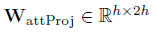

In [16]:
display.Image("./raw/a4_6.png")

> `self.att_projection = nn.Linear(self.hidden_size*2,self.hidden_size,bias=False)`

Applying

> `enc_hiddens_proj = self.att_projection(enc_hiddens)`

     2. Construct tensor `Y` of target sentences with shape (tgt_len, b, e) using the target model embeddings.
         where tgt_len = maximum target sentence length, b = batch size, e = embedding size.

> `Y = self.model_embeddings.target(target_padded)` # model_embeddings.target produces shape (tgt_len, b, e) -- sanity check gives torch.Size([20, 5, 3])

     3. Use the torch.split function to iterate over the time dimension of Y.
         Within the loop, this will give you Y_t of shape (1, b, e) where b = batch size, e = embedding size.
             - Squeeze Y_t into a tensor of dimension (b, e). 
             - Construct Ybar_t by concatenating Y_t with o_prev.
             - Use the step function to compute the the Decoder's next (cell, state) values
               as well as the new combined output o_t.
             - Append o_t to combined_outputs
             - Update o_prev to the new o_t.
             
    ### Use the following docs to implement this functionality:
    ###     Zeros Tensor:
    ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
    ###     Tensor Splitting (iteration):
    ###         https://pytorch.org/docs/stable/torch.html#torch.split
    ###     Tensor Dimension Squeezing:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Stacking:
    ###         https://pytorch.org/docs/stable/torch.html#torch.stack


> `        for Y_t in torch.split(Y, 1): # this will give you Y_t of shape (1, b, e)
            Y_t = torch.squeeze(Y_t,dim=0) # Squeeze Y_t into a tensor of dimension (b, e). 
            Ybar_t = torch.cat((Y_t,o_prev),dim=1) # Construct Ybar_t by concatenating Y_t with o_prev.
            dec_state, o_t, e_t = self.step(Ybar_t, dec_state, enc_hiddens, enc_hiddens_proj, enc_masks)
            combined_outputs.append(o_t) # Append o_t to combined_outputs
            o_prev = o_t # Update o_prev to the new o_t.
`


     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
         tensors shape (b, h), to a single tensor shape (tgt_len, b, h)
         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.

> `combined_outputs = torch.stack(combined_outputs, dim=0)`

Hence, `decode` returns `combined_outputs`

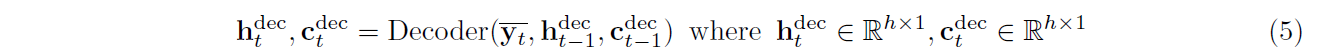

In [60]:
display.Image("./raw/a4_5a.png")

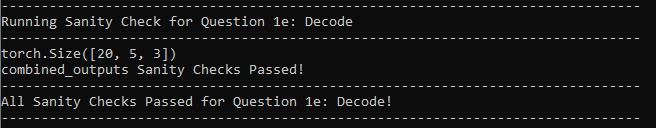

In [46]:
display.Image("./raw/a4_q1e_succ.png")

In [47]:
def decode(self, enc_hiddens: torch.Tensor, enc_masks: torch.Tensor,
            dec_init_state: Tuple[torch.Tensor, torch.Tensor], target_padded: torch.Tensor) -> torch.Tensor:
    """Compute combined output vectors for a batch.

    @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                 b = batch size, src_len = maximum source sentence length, h = hidden size.
    @param enc_masks (Tensor): Tensor of sentence masks (b, src_len), where
                                 b = batch size, src_len = maximum source sentence length.
    @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
    @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                   tgt_len = maximum target sentence length, b = batch size. 

    @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                    tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
    """
    # Chop of the <END> token for max length sentences.
    target_padded = target_padded[:-1]

    # Initialize the decoder state (hidden and cell)
    dec_state = dec_init_state

    # Initialize previous combined output vector o_{t-1} as zero
    batch_size = enc_hiddens.size(0)
    o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

    # Initialize a list we will use to collect the combined output o_t on each step
    combined_outputs = []

    ### YOUR CODE HERE (~9 Lines)
    ### TODO:
    ###     1. Apply the attention projection layer to `enc_hiddens` to obtain `enc_hiddens_proj`,
    ###         which should be shape (b, src_len, h),
    ###         where b = batch size, src_len = maximum source length, h = hidden size.
    ###         This is applying W_{attProj} to h^enc, as described in the PDF.
    ###     2. Construct tensor `Y` of target sentences with shape (tgt_len, b, e) using the target model embeddings.
    ###         where tgt_len = maximum target sentence length, b = batch size, e = embedding size.
    ###     3. Use the torch.split function to iterate over the time dimension of Y.
    ###         Within the loop, this will give you Y_t of shape (1, b, e) where b = batch size, e = embedding size.
    ###             - Squeeze Y_t into a tensor of dimension (b, e). 
    ###             - Construct Ybar_t by concatenating Y_t with o_prev.
    ###             - Use the step function to compute the the Decoder's next (cell, state) values
    ###               as well as the new combined output o_t.
    ###             - Append o_t to combined_outputs
    ###             - Update o_prev to the new o_t.
    ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
    ###         tensors shape (b, h), to a single tensor shape (tgt_len, b, h)
    ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.
    ###
    ### Note:
    ###    - When using the squeeze() function make sure to specify the dimension you want to squeeze
    ###      over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
    ###   
    ### Use the following docs to implement this functionality:
    ###     Zeros Tensor:
    ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
    ###     Tensor Splitting (iteration):
    ###         https://pytorch.org/docs/stable/torch.html#torch.split
    ###     Tensor Dimension Squeezing:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tensor Stacking:
    ###         https://pytorch.org/docs/stable/torch.html#torch.stack

    enc_hiddens_proj = self.att_projection(enc_hiddens)

    # Y = self.model_embeddings.target(target_padded)
    Y = self.model_embeddings.target(target_padded)
    print(Y.size())
    for Y_t in torch.split(Y, 1):
        Y_t = torch.squeeze(Y_t,dim=0)
        Ybar_t = torch.cat((Y_t,o_prev),dim=1)
        dec_state, o_t, e_t = self.step(Ybar_t, dec_state, enc_hiddens, enc_hiddens_proj, enc_masks)
        combined_outputs.append(o_t)
        o_prev = o_t
    combined_outputs = torch.stack(combined_outputs, dim=0)

    ### END YOUR CODE

    return combined_outputs

And we are done implementing the decoder segment!

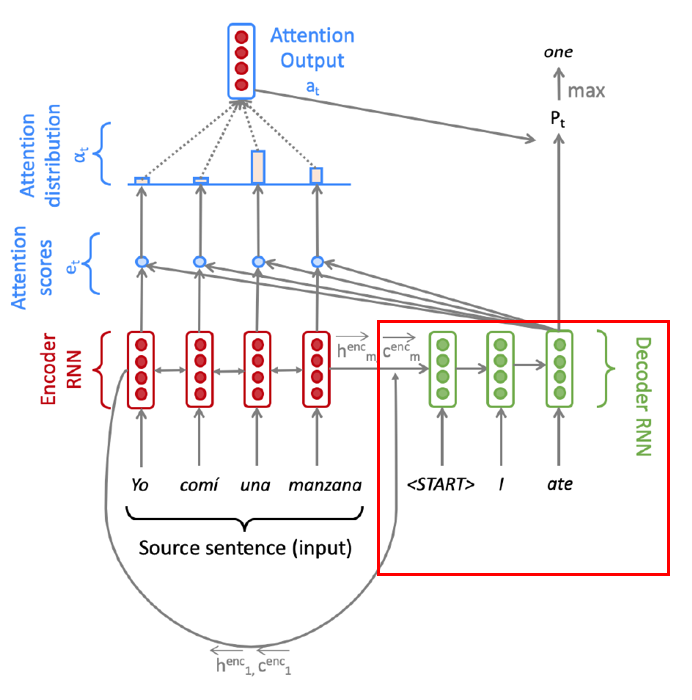

In [50]:
display.Image("./raw/a4_10.png")

#### Question 1f

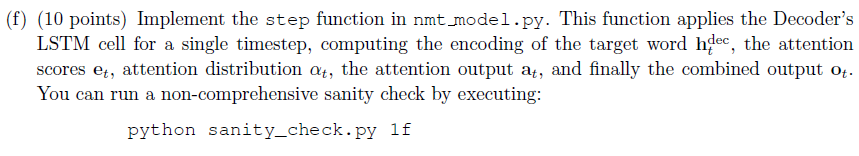

In [52]:
display.Image("./raw/a4_q1f.png")

In [ ]:
def step(self, Ybar_t: torch.Tensor,
        dec_state: Tuple[torch.Tensor, torch.Tensor],
        enc_hiddens: torch.Tensor,
        enc_hiddens_proj: torch.Tensor,
        enc_masks: torch.Tensor) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
    """ Compute one forward step of the LSTM decoder, including the attention computation.

    @param Ybar_t (Tensor): Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                            where b = batch size, e = embedding size, h = hidden size.
    @param dec_state (tuple(Tensor, Tensor)): Tuple of tensors both with shape (b, h), where b = batch size, h = hidden size.
            First tensor is decoder's prev hidden state, second tensor is decoder's prev cell.
    @param enc_hiddens (Tensor): Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                src_len = maximum source length, h = hidden size.
    @param enc_hiddens_proj (Tensor): Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                where b = batch size, src_len = maximum source length, h = hidden size.
    @param enc_masks (Tensor): Tensor of sentence masks shape (b, src_len),
                                where b = batch size, src_len is maximum source length. 

    @returns dec_state (tuple (Tensor, Tensor)): Tuple of tensors both shape (b, h), where b = batch size, h = hidden size.
            First tensor is decoder's new hidden state, second tensor is decoder's new cell.
    @returns combined_output (Tensor): Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
    @returns e_t (Tensor): Tensor of shape (b, src_len). It is attention scores distribution.
                            Note: You will not use this outside of this function.
                                  We are simply returning this value so that we can sanity check
                                  your implementation.
    """

    combined_output = None

    ### YOUR CODE HERE (~3 Lines)
    ### TODO:
    ###     1. Apply the decoder to `Ybar_t` and `dec_state`to obtain the new dec_state.
    ###     2. Split dec_state into its two parts (dec_hidden, dec_cell)
    ###     3. Compute the attention scores e_t, a Tensor shape (b, src_len). 
    ###        Note: b = batch_size, src_len = maximum source length, h = hidden size.
    ###
    ###       Hints:
    ###         - dec_hidden is shape (b, h) and corresponds to h^dec_t in the PDF (batched)
    ###         - enc_hiddens_proj is shape (b, src_len, h) and corresponds to W_{attProj} h^enc (batched).
    ###         - Use batched matrix multiplication (torch.bmm) to compute e_t.
    ###         - To get the tensors into the right shapes for bmm, you will need to do some squeezing and unsqueezing.
    ###         - When using the squeeze() function make sure to specify the dimension you want to squeeze
    ###             over. Otherwise, you will remove the batch dimension accidentally, if batch_size = 1.
    ###
    ### Use the following docs to implement this functionality:
    ###     Batch Multiplication:
    ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
    ###     Tensor Unsqueeze:
    ###         https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
    ###     Tensor Squeeze:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze


    ### END YOUR CODE

    # Set e_t to -inf where enc_masks has 1
    if enc_masks is not None:
        e_t.data.masked_fill_(enc_masks.byte(), -float('inf'))

    ### YOUR CODE HERE (~6 Lines)
    ### TODO:
    ###     1. Apply softmax to e_t to yield alpha_t
    ###     2. Use batched matrix multiplication between alpha_t and enc_hiddens to obtain the
    ###         attention output vector, a_t.
    #$$     Hints:
    ###           - alpha_t is shape (b, src_len)
    ###           - enc_hiddens is shape (b, src_len, 2h)
    ###           - a_t should be shape (b, 2h)
    ###           - You will need to do some squeezing and unsqueezing.
    ###     Note: b = batch size, src_len = maximum source length, h = hidden size.
    ###
    ###     3. Concatenate dec_hidden with a_t to compute tensor U_t
    ###     4. Apply the combined output projection layer to U_t to compute tensor V_t
    ###     5. Compute tensor O_t by first applying the Tanh function and then the dropout layer.
    ###
    ### Use the following docs to implement this functionality:
    ###     Softmax:
    ###         https://pytorch.org/docs/stable/nn.html#torch.nn.functional.softmax
    ###     Batch Multiplication:
    ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
    ###     Tensor View:
    ###         https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view
    ###     Tensor Concatenation:
    ###         https://pytorch.org/docs/stable/torch.html#torch.cat
    ###     Tanh:
    ###         https://pytorch.org/docs/stable/torch.html#torch.tanh


    ### END YOUR CODE

 Compute one forward step of the LSTM decoder, including the attention computation.

`step` takes in 5 parameters

Ybar_t: torch.Tensor,

dec_state: Tuple[torch.Tensor, torch.Tensor],

enc_hiddens: torch.Tensor,

enc_hiddens_proj: torch.Tensor,

enc_masks: torch.Tensor


     1. Apply the decoder to `Ybar_t` and `dec_state`to obtain the new dec_state.
     2. Split dec_state into its two parts (dec_hidden, dec_cell)
     3. Compute the attention scores e_t, a Tensor shape (b, src_len). 
        Note: b = batch_size, src_len = maximum source length, h = hidden size.
        
    ### Use the following docs to implement this functionality:
    ###     Batch Multiplication:
    ###        https://pytorch.org/docs/stable/torch.html#torch.bmm
    ###     Tensor Unsqueeze:
    ###         https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
    ###     Tensor Squeeze:
    ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze

> `dec_state = self.decoder(Ybar_t, dec_state)` # self.decoder = 

nn.LSTMCell(input_size=embed_size+self.hidden_size,hidden_size=self.hidden_size,bias=True)

nn.LSTMCell outputs: (h_1, c_1)

h_1 of shape (batch, hidden_size): tensor containing the next hidden state for each element in the batch

c_1 of shape (batch, hidden_size): tensor containing the next cell state for each element in the batch

> `dec_hidden, dec_cell = dec_state`

Recall

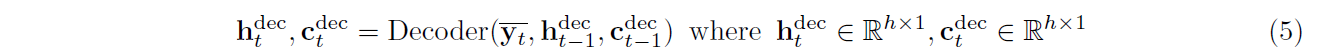

In [62]:
display.Image("./raw/a4_5a.png")

Next task, compute multiplicative attention

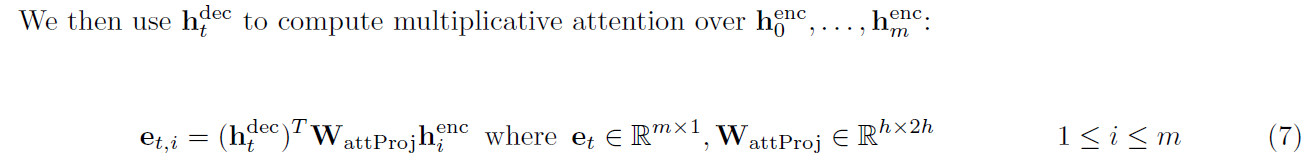

In [71]:
display.Image("./raw/a4_11.png")

As recommended to use Torch.bmm,

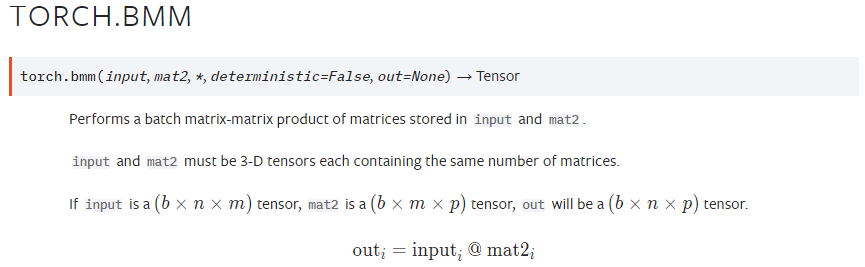

In [66]:
display.Image("./raw/a4_12.png")

recall,
- `enc_hiddens_proj = W_att_proj # shape (b, src_len, h)`
- `dec_hidden = h_t^dec # shape (b, h)`

to unsqueeze `dec_hidden` so that the shapes matches

> `dec_hidden = torch.unsqueeze(dec_hidden, dim=2) # shape (b,h,1)`

Then we apply `torch.bmm`

> `e_t = torch.bmm(enc_hiddens_proj, dec_hidden) # shape (b, src_len, 1)`

and squeeze `e_t` to shape (b, src_len)

> `e_t = torch.squeeze(e_t, dim=2) # shape (b, src_len)`

Now, we compute Softmax

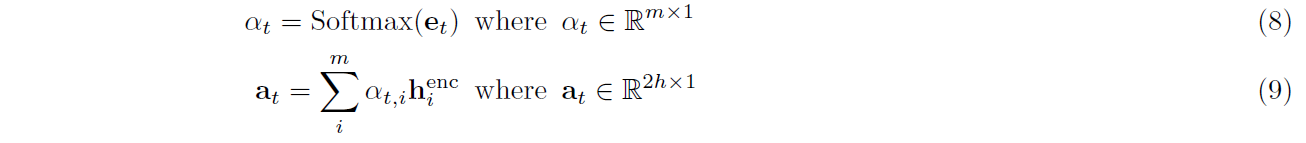

In [72]:
display.Image("./raw/a4_13.png")

> `alpha_t = F.softmax(e_t)`

> `a_t = torch.bmm(alpha_t, enc_hiddens)`

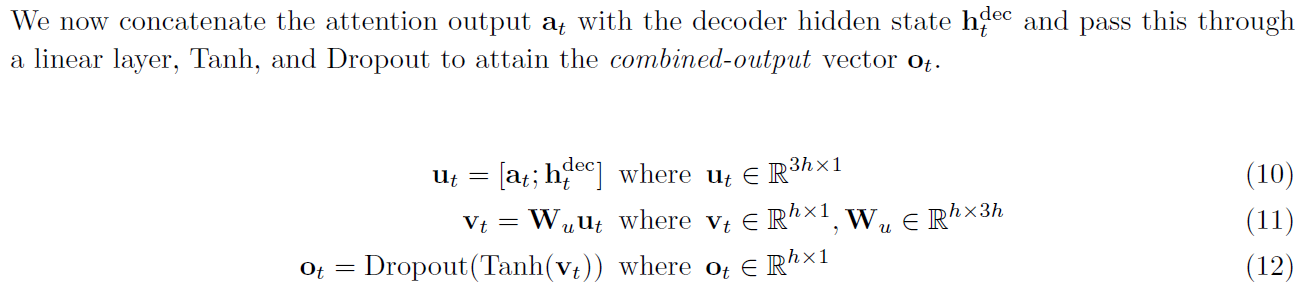

In [73]:
display.Image("./raw/a4_14.png")

> `u_t = torch.concat((a_t, dec_hidden), dim=1)`


Next, compute W_u

In [74]:
display.Image("./raw/a4_7.png")

> `v_t = self.combined_output_projection(u_t)`

finally, apply the dropout layer

> `O_t = self.dropout(torch.tanh(v_t))`

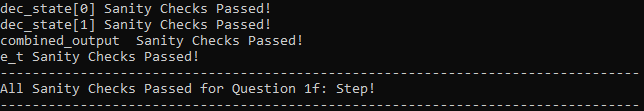

In [77]:
display.Image("./raw/a4_q1f_succ.png")

Then, compute the probability distribution over target words

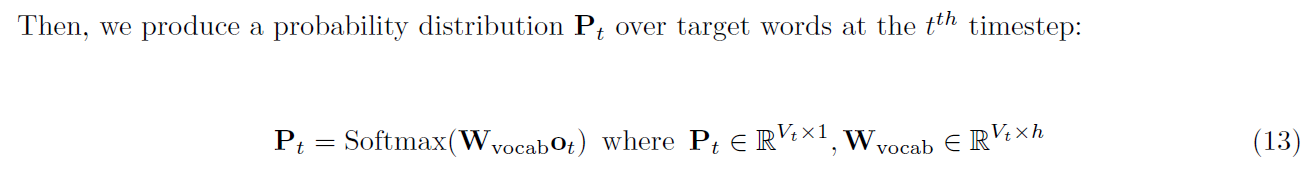

In [81]:
display.Image("./raw/a4_15.png")

In `forward`,

we find `P` already implemented for us.

`P = F.log_softmax(self.target_vocab_projection(combined_outputs), dim=-1)` 

recall that `self.target_vocab_projection` (Linear Layer with no bias) was initialized, called W_{vocab} in the PDF.